# Causal Inference with Propensity Score

## Import Libraries

In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats
from scipy.special import expit

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Generation

In [2]:
n = 200

x_1 = np.random.randint(15, 76, n)
x_2 = np.random.randint(0, 2, n)

e_z = np.random.randn(n)
z_base = x_1 + (1-x_2)*10 - 40 + 5*e_z
z_prob = expit(0.1*z_base)

Z = np.array([])

for i in range(n):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

e_y = np.random.randn(n)
Y = -x_1 + 30*x_2 + 10*Z + 80 + 10*e_y

df = pd.DataFrame({'X_1': x_1,
                   'X_2': x_2,
                   'Z': Z,
                   'Y': Y,
                   })

df

,X_1,X_2,Z,Y
0,59,0,1.0,37.412692
1,27,1,0.0,89.308754
2,52,1,0.0,51.951540
3,58,0,0.0,9.222964
4,26,0,1.0,84.446522
...,...,...,...,...
195,35,0,1.0,74.933412
196,62,1,1.0,53.551980
197,22,1,0.0,73.159330
198,64,0,1.0,25.083688


## Mere Comparison of Means

In [3]:
df.groupby('Z').mean()

,X_1,X_2,Y
Z,,,
0.0,31.785714,0.600000,65.760922
1.0,53.607692,0.369231,48.834912


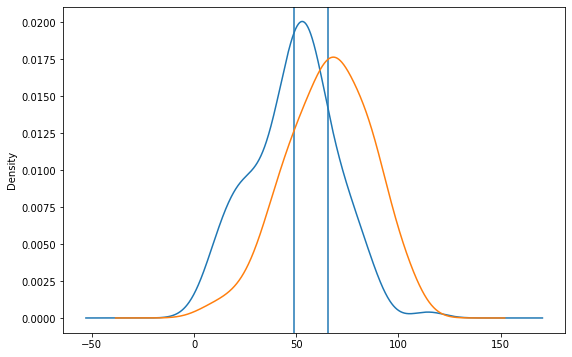

In [4]:
for _z in df.Z.unique():
    _df = df[df.Z == _z].Y
    plt.axvline(x=_df.mean())
    _df.plot.kde(figsize=(9,6))

In [5]:
df[df.Z == 1].Y.mean() - df[df.Z == 0].Y.mean()

-16.926009242963737

In [6]:
data = sm.add_constant(df)
endog = data['Y']
exog = data[['X_1', 'X_2', 'Z', 'const']]

In [7]:
model = sm.OLS(endog=endog, exog=exog)
result = model.fit()

In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     254.7
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           2.37e-67
Time:                        11:49:07   Log-Likelihood:                -742.59
No. Observations:                 200   AIC:                             1493.
Df Residuals:                     196   BIC:                             1506.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X_1           -1.0043      0.051    -19.717      0.0

In [9]:
result.params['Z']

11.856673285767876

## IPTW (Inverse Probability of Treatment Weighting)

In [10]:
data = sm.add_constant(df)
endog = data['Z']
exog = data[['X_1', 'X_2', 'const']]

In [11]:
# model = sm.Logit(endog=endog, exog=exog)
model = sm.GLM(endog=endog, exog=exog, family=sm.families.Binomial())
result = model.fit(disp=0)

In [12]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Z   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.705
Date:                Mon, 01 Mar 2021   Deviance:                       159.41
Time:                        11:49:10   Pearson chi2:                     185.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X_1            0.1103      0.016      7.030      0.0

### Propensity Score

In [13]:
p_score = result.predict()

In [14]:
p_score[:10]

array([0.96610353, 0.11935222, 0.6812249 , 0.96229908, 0.42786171,
       0.44189665, 0.98569186, 0.96229908, 0.99333866, 0.59178172])

In [15]:
p_score[:10].round(0)

array([1., 0., 1., 1., 0., 0., 1., 1., 1., 1.])

### Compute ATE

In [16]:
ATE_i = (data.Y / p_score * data.Z) - (data.Y / (1 - p_score) * (1 - data.Z))
ATE_i.mean()

12.44586432142446

## Doubly Robust Estimation

In [17]:
data = df.copy()
model = LinearRegression().fit(
    data[['X_1', 'X_2', 'Z']],
    data['Y']
)

In [18]:
Y_0 = model.predict(
    data
    .assign(Z=np.zeros(len(data)))
    .drop(columns='Y')
)
Y_1 = model.predict(
    data
    .assign(Z=np.ones(len(data)))
    .drop(columns='Y')
)

In [19]:
model = LogisticRegression().fit(
    data[['X_1', 'X_2']],
    data['Z']
)

### Propensity Score

In [20]:
p_score = model.predict_proba(data[['X_1', 'X_2']])

In [21]:
p_score[:5]

array([[0.04171759, 0.95828241],
       [0.85690808, 0.14309192],
       [0.29700176, 0.70299824],
       [0.04616973, 0.95383027],
       [0.59042129, 0.40957871]])

### Compute ATE

In [22]:
ATE_1_i = data.Y / p_score[:, 1] * data.Z + (1 - data.Z / p_score[:, 1]) * Y_1
ATE_0_i = data.Y / p_score[:, 0] * (1 - data.Z) + (1 - (1 - data.Z) / p_score[:, 0]) * Y_0

In [23]:
(ATE_1_i - ATE_0_i).mean()

11.395185185448206